In [21]:
import keras_tuner as kt
from tensorflow import keras
import numpy as np
import xarray as xr
import dask
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *
from keras.layers import BatchNormalization
import tensorflow_probability as tfp
import clif
import clif.visualization as cviz
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model

In [2]:
cd /Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data

/Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data


In [3]:
rm -rf trials

In [4]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks={'n': 1})
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']

In [5]:
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks={'n': 1})
Y_obs = dataset_obs['SWCF']
Y_scalar=Y_obs.values.var()
Y_shift=Y_obs.values.mean()
Y_np = (Y.values-Y_obs.values)/np.sqrt(Y_scalar)
Y_np = np.array([Yi.flatten() for Yi in Y_np])

In [6]:
X_np = X.values
feature_coords = dataset['x'].values
print("names of the feature coordinates:\n",feature_coords)

feature_bounds = dataset['lhs_bnds'].values
print("List of upper and lower bounds:\n", list(feature_bounds))

from tesuract.preprocessing import DomainScaler
feature_transform = DomainScaler(
                dim=X_np.shape[1],
                input_range=list(feature_bounds),
                output_range=(-1,1),
                )
X_s = feature_transform.fit_transform(X_np)
print("Range of scaled features:({0:.3f},{1:.3f})".format(X_s.min(), X_s.max()))

names of the feature coordinates:
 ['ice_sed_ai' 'clubb_c1' 'clubb_gamma_coef' 'zmconv_tau' 'zmconv_dmpdz']
List of upper and lower bounds:
 [array([ 350., 1400.]), array([1., 5.]), array([0.1, 0.5]), array([ 1800., 14400.]), array([-0.002 , -0.0001])]
Range of scaled features:(-1.000,0.998)


In [7]:
index=np.random.choice(250,50)
X_test=X[index]
Y_test=Y[index]
Index_x_bool=np.array([True]*250)
Index_x_bool[index]=False
X_train=X[Index_x_bool]
Y_train=Y[Index_x_bool]

Text(0.5, 1.0, 'Cumulative explained ratio')

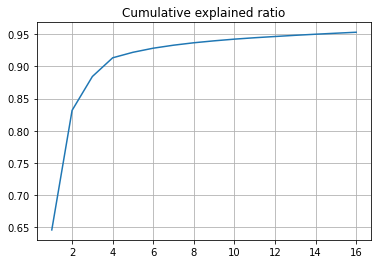

In [8]:
# Re-label the data to X and Y
X = X_s.copy()
Y = Y_np.copy()

# Import PCA transform from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=16,whiten=True)
Yhat = pca.fit_transform(Y)

# We can plot the explained variance which shows how much of the total variance the PCA components capture
import matplotlib.pyplot as plt
evr = pca.explained_variance_ratio_
plt.plot(range(1,len(evr)+1),np.cumsum(evr))
plt.grid(True)
plt.title("Cumulative explained ratio")

In [9]:
Y_train2=Yhat[Index_x_bool]
Y_test2=Yhat[index]

In [10]:
def custom_loss(y_actual,y_pred):
    custom_loss=kb.square(y_actual-y_pred)
    return custom_loss

In [14]:
def build_model_PCA(hp):
    model = keras.Sequential()
    model.add(keras.layers.BatchNormalization(input_shape=(5,)))
    model.add(tf.keras.layers.Flatten())
    model.add(keras.layers.Dense(
    units=hp.Int("units", min_value=20, max_value=100, step=20),
    activation=hp.Choice("activation", ["relu", "tanh","leaky_relu"]))
    )
#     if hp.Boolean("dropout"):
#         model.add(keras.layers.Dropout(rate=0.25))
        
    model.add(keras.layers.Dense(
    units=hp.Int("units2", min_value=20, max_value=100, step=20),
    activation=hp.Choice("activation", ["relu", "tanh","leaky_relu"]))
    )
    model.add(keras.layers.Dense(
    units=hp.Int("units3", min_value=20, max_value=100, step=20),
    activation=hp.Choice("activation", "leaky_relu"))
    )
    model.add(keras.layers.Dense(16, activation='leaky_relu'))
    hp_learning_rate=hp.Choice("learning_rate",values=[1e-2,1e-3,1e-4])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate),loss=custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])
    return model

In [15]:
tuner = kt.Hyperband(
    build_model_PCA,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    overwrite=True,
    directory='trials',)

In [16]:
tuner.search(X_train, Y_train2, epochs=50, validation_data=(X_test, Y_test2))

Trial 30 Complete [00h 00m 02s]
val_loss: 1.1802036762237549

Best val_loss So Far: 0.9462693333625793
Total elapsed time: 00h 00m 41s
INFO:tensorflow:Oracle triggered exit


In [17]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 5)                20        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 80)                480       
                                                                 
 dense_1 (Dense)             (None, 60)                4860      
                                                                 
 dense_2 (Dense)             (None, 60)                3660      
                                                                 
 dense_3 (Dense)             (None, 16)                976       
                                                        

In [18]:
Y_Pred=best_model.predict(X_test)

In [19]:
Y_orig_test=pca.inverse_transform(Y_Pred)
Y_test2=Y[index]


In [23]:
mse=np.mean(np.square(Y_orig_test-Y_test2))

In [24]:
rmse=np.sqrt(mse)

In [25]:
print("mse is:",mse,"rmse:",rmse)

mse is: 0.017274601 rmse: 0.13143288


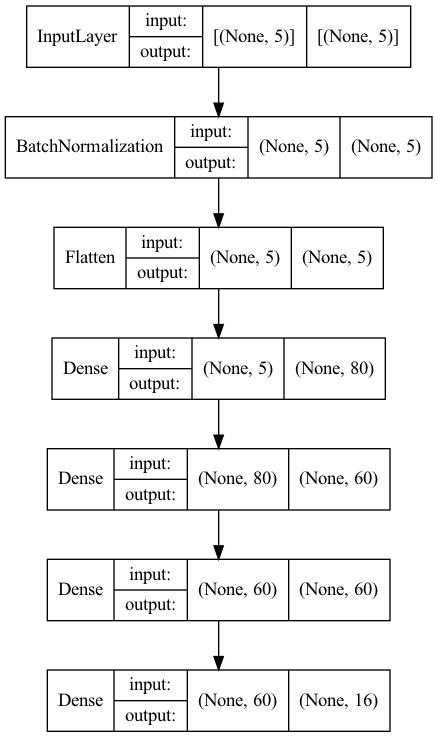

In [27]:
plot_model(best_model, to_file='large_model_plot.png', show_shapes=True, show_layer_names=False)